## Selecting only digits 1 and 9

In [26]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.,), (1.,))
])

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
train_indices = [i for i in range(len(train_dataset)) if train_dataset.targets[i] in [1, 9]]
test_indices = [i for i in range(len(test_dataset)) if test_dataset.targets[i] in [1, 9]]
filtered_train_dataset = Subset(train_dataset, train_indices)
filtered_test_dataset = Subset(test_dataset, test_indices)
batch_size = 64
train_mnistloader = DataLoader(filtered_train_dataset, batch_size=batch_size, shuffle=True)
val_mnistloader = DataLoader(filtered_test_dataset, batch_size=batch_size, shuffle=False)
device = "cuda" if torch.cuda.is_available() else "cpu"

100%|██████████| 9912422/9912422 [00:00<00:00, 206676731.03it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 28881/28881 [00:00<00:00, 44683029.81it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 79284313.66it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


100%|██████████| 4542/4542 [00:00<00:00, 6331182.71it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [28]:
# for imgs,_ in train_mnistloader:
#     img = imgs[0]
#     print(img.shape,img[0])
#     break

## Geomloss for Sinkhorn loss for optimal transport

In [ ]:
%%capture
!pip install geomloss

## Autoencoder with latent dimension mapping to normal distrbution and optimizing optimal transport loss wrt to Normal Distribution
**Also applying reparametrization trick for end to end backpropagation.**

In [31]:
import torch
import torch.nn as nn
import torch.optim as optim
from geomloss import SamplesLoss
from torch.utils.data import DataLoader
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(4096, latent_dim * 2),
            nn.BatchNorm1d(latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 7 * 7),  
            nn.BatchNorm1d(256 * 7 * 7),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 7, 7)),  
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 1, kernel_size=3, stride=1, padding=1),  
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        mu, log_var = torch.chunk(z, 2, dim=1)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, log_var):#####mapping to normal distribution but reparametrization trick for backpropagation
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, z


latent_dim = 64
learning_rate = 0.1
num_epochs = 15
batch_size = 64
beta = 0.15  ## weighting optimaltransport loss by beta

model = VAE(latent_dim).to(device)

reconstruction_loss = nn.BCELoss(reduction='sum')
optimaltransportloss_fn = SamplesLoss("sinkhorn", p=2, blur=0.05)##optimal transport loss

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

prev_loss = float('inf')
best_loss = float('inf')

losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Validation loop
    model.eval()
    val_loader = tqdm(val_mnistloader, desc=f'Epoch {epoch + 1}/{num_epochs} (val)', total=len(val_mnistloader))
    for batch_idx, (data,_) in enumerate(val_loader):
        data = data.to(device)
        with torch.no_grad():
            recon_batch, z = model(data)
            loss = reconstruction_loss(recon_batch, data)
            normal_samples = torch.randn_like(z)
            optimaltransportloss = optimaltransportloss_fn(z, normal_samples)
            loss += beta*optimaltransportloss
            val_loss += loss.item()
            val_loader.set_postfix(val_loss=val_loss / ((batch_idx + 1)))
        del data

    if val_loss / len(val_mnistloader) >= prev_loss:
        learning_rate *= 0.1
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Changing learning rate to {learning_rate}")
    prev_loss = val_loss/(len(val_mnistloader))

    # Training loop
    model.train()
    train_loader = tqdm(train_mnistloader, desc=f'Epoch {epoch + 1}/{num_epochs} (train)', total=len(train_mnistloader))
    for batch_idx, (data,_) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, z = model(data)
        loss = reconstruction_loss(recon_batch, data)
        normal_samples = torch.randn_like(z)
        optimaltransportloss = optimaltransportloss_fn(z, normal_samples)
        loss += beta*optimaltransportloss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        train_loss += loss.item()
        train_loader.set_postfix(train_loss=train_loss / ((batch_idx + 1)))
    del data
    
    losses.append(val_loss)
    if val_loss<best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(),"model.pth")
        print("saved model to model.pth")


Epoch 1/15 (train): 100%|██████████| 199/199 [00:07<00:00, 26.63it/s, train_loss=8.16e+3]


saved model to model.pth


Epoch 2/15 (train): 100%|██████████| 199/199 [00:07<00:00, 26.81it/s, train_loss=4.01e+3]


saved model to model.pth


Epoch 3/15 (train): 100%|██████████| 199/199 [00:07<00:00, 26.14it/s, train_loss=3.68e+3]


saved model to model.pth


Epoch 4/15 (val): 100%|██████████| 34/34 [00:01<00:00, 32.50it/s, val_loss=3.55e+3]


Changing learning rate to 0.010000000000000002


Epoch 5/15 (train): 100%|██████████| 199/199 [00:07<00:00, 27.77it/s, train_loss=3.12e+3]


saved model to model.pth


Epoch 6/15 (train): 100%|██████████| 199/199 [00:07<00:00, 27.32it/s, train_loss=3.09e+3]


saved model to model.pth


Epoch 7/15 (train): 100%|██████████| 199/199 [00:07<00:00, 27.00it/s, train_loss=3.05e+3]


saved model to model.pth


Epoch 8/15 (train): 100%|██████████| 199/199 [00:07<00:00, 27.04it/s, train_loss=3.02e+3]


saved model to model.pth


Epoch 9/15 (train): 100%|██████████| 199/199 [00:07<00:00, 27.16it/s, train_loss=3e+3]   


saved model to model.pth


Epoch 10/15 (val): 100%|██████████| 34/34 [00:01<00:00, 32.98it/s, val_loss=2.82e+3]


Changing learning rate to 0.0010000000000000002


Epoch 11/15 (train): 100%|██████████| 199/199 [00:07<00:00, 26.87it/s, train_loss=2.94e+3]


saved model to model.pth


Epoch 12/15 (val): 100%|██████████| 34/34 [00:01<00:00, 32.34it/s, val_loss=2.77e+3]


Changing learning rate to 0.00010000000000000003


Epoch 13/15 (val): 100%|██████████| 34/34 [00:01<00:00, 33.44it/s, val_loss=2.77e+3]


Changing learning rate to 1.0000000000000004e-05


Epoch 14/15 (val): 100%|██████████| 34/34 [00:01<00:00, 33.50it/s, val_loss=2.77e+3]


Changing learning rate to 1.0000000000000004e-06


Epoch 15/15 (train): 100%|██████████| 199/199 [00:07<00:00, 27.19it/s, train_loss=2.92e+3]

saved model to model.pth


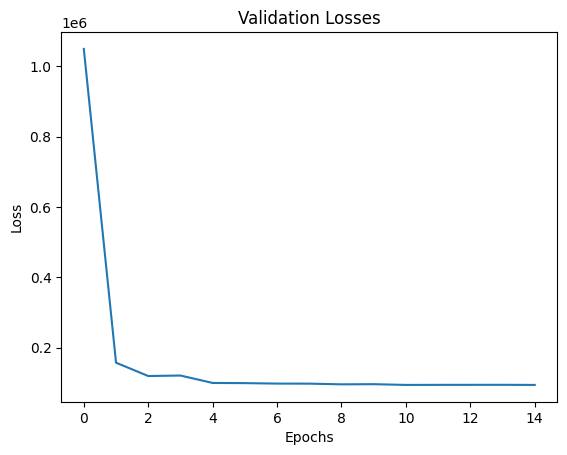

In [32]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [33]:
try:
    del model
    print("deleted model")
except:
    None
torch.cuda.empty_cache()

deleted model


tensor(62.6666, device='cuda:0', grad_fn=<BinaryCrossEntropyBackward0>)
tensor(85.6434, device='cuda:0', grad_fn=<AddBackward0>)


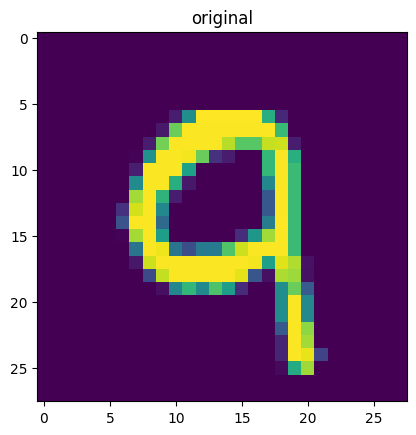

In [42]:
import random
import matplotlib.pyplot as plt
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()
r = random.randint(0,1024)
dataset = filtered_test_dataset
imgorig = dataset[r][0]
imgrecons = model(imgorig.unsqueeze(0).to(device))[0]
recon_batch, z = model(imgorig.unsqueeze(0).to(device))
loss = reconstruction_loss(recon_batch, imgorig.unsqueeze(0).to(device))
print(loss)
normal_samples = torch.randn_like(z)
optimaltransportloss = 0.15*optimaltransportloss_fn(z, normal_samples)
loss += optimaltransportloss
print(loss)
# print(np.array(imgrecons.cpu()).shape)
pltorig = imgorig.permute(1,2,0).cpu().numpy()
pltrecons = imgrecons.permute(0,2,3,1).detach().cpu().numpy()[0]
plt.title("original")
plt.imshow(pltorig)

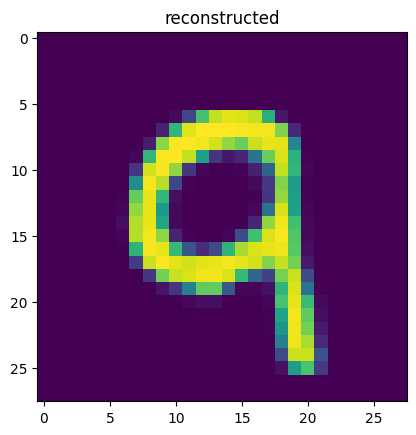

In [44]:
plt.title("reconstructed")
plt.imshow(pltrecons)

## Sampling from normal distribution randomly

torch.Size([28, 28, 1])


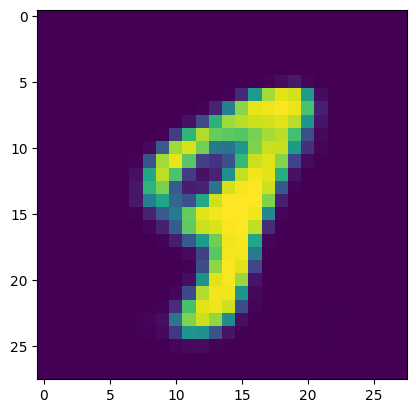

In [52]:
import random
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()

imgorig = torch.randn((1,latent_dim))##normal distribution

imgrecons = model.decoder(imgorig.to(device))[0]
imgrecons = imgrecons.permute(1,2,0).detach().cpu()
print((imgrecons).shape)
plt.imshow(imgrecons)

## Image generation on quarks/gluon dataset

In [53]:
!pip install gdown
import gdown
import gdown
import zipfile
import os
url = 'https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr'
output_path = 'large_file.hdf5'
gdown.download(url, output_path, quiet=False)
import matplotlib.pyplot as plt
import numpy as np
import h5py
with h5py.File('large_file.hdf5', 'r') as file:
    train_imgs = np.array(file['X_jets'][:4096])
    test_imgs = np.array(file['X_jets'][4096:4096+1024])
    train_labels = np.array(file['y'][:4096])
    train_labels = np.array(file['y'][4096:4096+1024])
    print(train_imgs[0].shape)

Downloading...
From (original): https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr
From (redirected): https://drive.google.com/uc?id=1WO2K-SfU2dntGU4Bb3IYBp9Rh7rtTYEr&confirm=t&uuid=0a82e0c8-9171-48ca-88b6-2afb6707ded7
To: /kaggle/working/large_file.hdf5
100%|██████████| 701M/701M [00:03<00:00, 208MB/s] 


(125, 125, 3)


In [54]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.v2 as transforms
class Data(torch.utils.data.Dataset):
    def __init__(self,imgs):
        super().__init__()
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize([0.,0.,0.],[1.,1.,1.]),
        ])
        self.imgs = imgs
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self,idx):
        img = self.transform(self.imgs[idx])
        img2 = torch.zeros((3,128,128)).to(img.dtype)
        img2[:,:125,:125] = img
        return img2

train_loader = torch.utils.data.DataLoader(Data(train_imgs), batch_size=64)
val_loader = torch.utils.data.DataLoader(Data(test_imgs), batch_size=64)

In [55]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [57]:
from geomloss import SamplesLoss
from torch.utils.data import DataLoader
from tqdm import tqdm

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super(VAE, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 128, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 256, kernel_size=3, stride=2, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Flatten(),
            nn.Linear(65536, latent_dim * 2),
            nn.BatchNorm1d(latent_dim * 2)
        )

        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 256 * 8 * 8),
            nn.BatchNorm1d(256 * 8 * 8),
            nn.ReLU(inplace=True),
            nn.Unflatten(1, (256, 8, 8)),
            nn.ConvTranspose2d(256, 128, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(128, 64, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.ConvTranspose2d(32, 3, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def encode(self, x):
        z = self.encoder(x)
        mu, log_var = torch.chunk(z, 2, dim=1)
        return mu, log_var

    def decode(self, z):
        return self.decoder(z)

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_recon = self.decode(z)
        return x_recon, z

latent_dim = 128
learning_rate = 0.1
num_epochs = 15
batch_size = 64

model = VAE(latent_dim).to(device)
reconstruction_loss = nn.MSELoss(reduction='sum')

optimaltransportloss_fn = SamplesLoss("sinkhorn", p=2, blur=0.05)

optimizer = optim.Adam(model.parameters(), lr=learning_rate)

prev_loss = float('inf')
best_loss = float('inf')
losses = []
for epoch in range(num_epochs):
    train_loss = 0.0
    val_loss = 0.0

    # Validation loop
    model.eval()
    val_loader = tqdm(val_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (val)')
    for batch_idx, data in enumerate(val_loader):
        data = data.to(device)
        with torch.no_grad():
            recon_batch, z = model(data)
            loss = reconstruction_loss(recon_batch, data)
            normal_samples = torch.randn_like(z)
            optimaltransportloss = optimaltransportloss_fn(z, normal_samples)
            loss += 0.15*optimaltransportloss
            val_loss += loss.item()
            val_loader.set_postfix(val_loss=val_loss / ((batch_idx + 1)))
        del data

    if val_loss / len(val_loader) >= prev_loss:
        learning_rate *= 0.1
        optimizer = optim.Adam(model.parameters(), lr=learning_rate)
        print(f"Changing learning rate to {learning_rate}")
    prev_loss = val_loss/(len(val_loader))

    # Training loop
    model.train()
    train_loader = tqdm(train_loader, desc=f'Epoch {epoch + 1}/{num_epochs} (train)')
    for batch_idx, data in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, z = model(data)
        loss = reconstruction_loss(recon_batch, data)
        normal_samples = torch.randn_like(z)
        optimaltransportloss = optimaltransportloss_fn(z, normal_samples)
        loss += 0.15*optimaltransportloss
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        train_loader.set_postfix(train_loss=train_loss / ((batch_idx + 1)))
    del data
    
    losses.append(val_loss)

    if val_loss<best_loss:
        best_loss = val_loss
        torch.save(model.state_dict(),"model.pth")
        print("saved model to model.pth")

Epoch 1/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.17it/s, train_loss=1.47e+4]


saved model to model.pth


Epoch 2/15 (train): 100%|██████████| 64/64 [00:04<00:00, 15.96it/s, train_loss=82.4]


saved model to model.pth


Epoch 3/15 (val): 100%|██████████| 16/16 [00:00<00:00, 25.28it/s, val_loss=46.4]


Changing learning rate to 0.010000000000000002


Epoch 4/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.41it/s, train_loss=34]  


saved model to model.pth


Epoch 5/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.56it/s, train_loss=30.7]


saved model to model.pth


Epoch 6/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.43it/s, train_loss=29.5]


saved model to model.pth


Epoch 7/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.51it/s, train_loss=28.7]


saved model to model.pth


Epoch 8/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.19it/s, train_loss=28.2]


saved model to model.pth


Epoch 9/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.61it/s, train_loss=27.9]


saved model to model.pth


Epoch 10/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.40it/s, train_loss=27.4]


saved model to model.pth


Epoch 11/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.53it/s, train_loss=27]  


saved model to model.pth


Epoch 12/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.52it/s, train_loss=26.6]


saved model to model.pth


Epoch 13/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.42it/s, train_loss=26.4]


saved model to model.pth


Epoch 14/15 (val): 100%|██████████| 16/16 [00:00<00:00, 25.70it/s, val_loss=24]  


Changing learning rate to 0.0010000000000000002


Epoch 15/15 (train): 100%|██████████| 64/64 [00:03<00:00, 16.06it/s, train_loss=25.8]


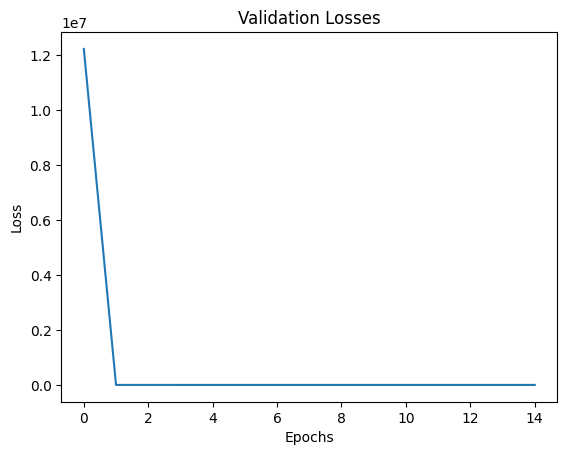

In [58]:
import matplotlib.pyplot as plt

plt.plot(losses)
plt.title("Validation Losses")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()

In [59]:
try:
    del model
    print("deleted model")
except:
    None
torch.cuda.empty_cache()

deleted model


tensor(0.1367, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(10.0243, device='cuda:0', grad_fn=<AddBackward0>)


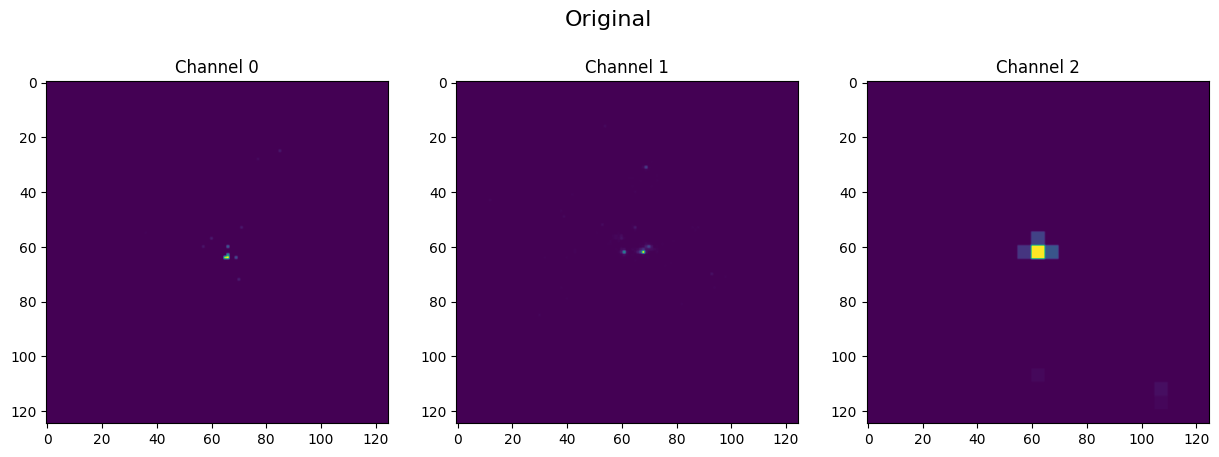

In [64]:
import random
model = VAE(latent_dim).to(device)
model.load_state_dict(torch.load("model.pth"))
model.eval()
r = random.randint(0,1024)
dataset = Data(test_imgs)
imgorig = dataset[r]
imgrecons = model(imgorig.unsqueeze(0).to(device))[0]
recon_batch, z = model(imgorig.unsqueeze(0).to(device))
loss = reconstruction_loss(recon_batch, imgorig.unsqueeze(0).to(device))
print(loss)
normal_samples = torch.randn_like(z)
optimaltransportloss = 0.15*optimaltransportloss_fn(z, normal_samples)
loss += optimaltransportloss
print(loss)
# print(np.array(imgrecons.cpu()).shape)
pltorig = imgorig.permute(1,2,0).cpu().numpy()[:125,:125,:]
pltrecons = imgrecons.permute(0,2,3,1).detach().cpu().numpy()[0][:125,:125,:]
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(pltorig[:,:,0])
axs[0].set_title('Channel 0')

axs[1].imshow(pltorig[:,:,1])
axs[1].set_title('Channel 1')

axs[2].imshow(pltorig[:,:,2])
axs[2].set_title('Channel 2')

plt.suptitle('Original', fontsize=16)  # Set a common title for all subplots in the x-axis direction
plt.savefig('pltrecons')  # Save the figure as "pltrecons.png"
plt.show()


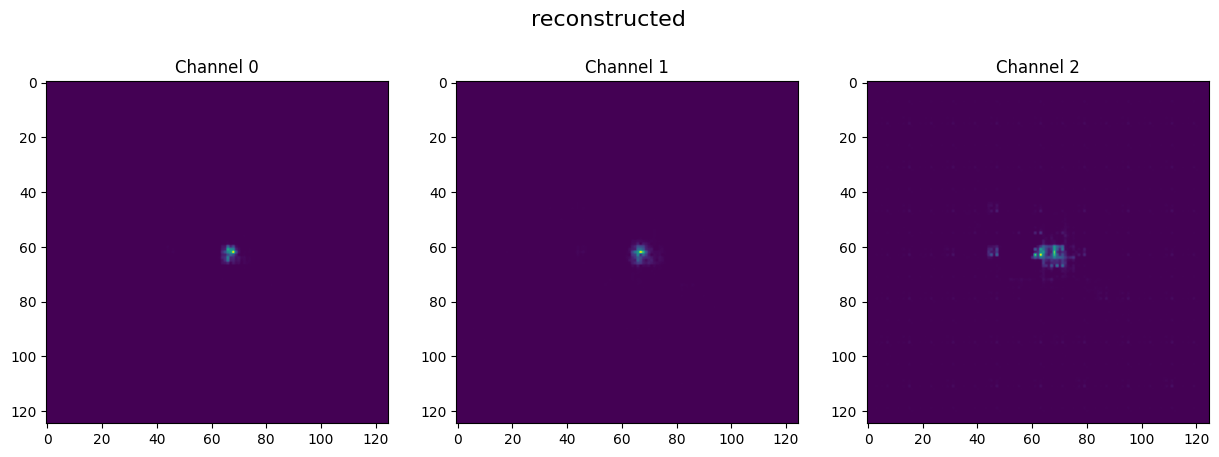

In [65]:
fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs[0].imshow(pltrecons[:,:,0])
axs[0].set_title('Channel 0')

axs[1].imshow(pltrecons[:,:,1])
axs[1].set_title('Channel 1')

axs[2].imshow(pltrecons[:,:,2])
axs[2].set_title('Channel 2')

plt.suptitle('reconstructed', fontsize=16)  # Set a common title for all subplots in the x-axis direction
plt.show()
